# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
import glob
import os
from matplotlib import cm
from matplotlib.colors import Normalize

colors = sns.color_palette("hls", 8)   # Colors
title_size = 16                        # Size title
axis_size = 14                         # Size axis label
value_size = 10                        # Size values on axis
legend_size = 12                       # Size legend

The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters: $\sigma$ and $\mu$.

## Exercise 08.1 
### Assignment

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:

$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}
$$

### Resolution

To compute $\langle {\hat H} \rangle_T = \int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$ I sampled $\rho(x) = \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}$ using Metropolis algorithm in `void metropolis_algorithm()` function. Each step of the algorithm is implemented in `void metropolis_step()` function:

```cpp
void metropolis_step(Random& rn, Wavefunction wf, double& x_prec, double delta, int& acceptance)
{
 double x_new = x_prec + rn.Rannyu(-delta, delta);	// New position
 double A = min(1., wf.Modq_wf(x_new) / wf.Modq_wf(x_prec));     // Transition probability with |\psi(x)|^2 

 // Accept  or reject new position
 if (rn.Rannyu() <= A)
 {
  x_prec = x_new;
  acceptance ++;
 }    
} 
```

where `wf.Modq_wf()` method returns the square module of the wave function.

With the $x$ values extracted from this distribution, I calculated $\langle {\hat H} \rangle_T = \int dx \rho(x) \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$ evaluating 

$$\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}  = \frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)} + V(x)$$

where $\hbar=1$ and $m=1$ and

$$\frac{\partial^2}{\partial x^2} {\Psi_T(x)} = \left[\frac{(x-\mu)^2}{\sigma^4} - \frac{1}{\sigma^2}\right]e^{-\frac{(x-\mu)^2}{2\sigma^2}} + \left[\frac{(x+\mu)^2}{\sigma^4} - \frac{1}{\sigma^2}\right]e^{-\frac{(x+\mu)^2}{2\sigma^2}}$$

I used data blocking with $N = 100$ blocks and $L=10^5$ throws in each block, after 40 blocks used for equilibration.

For each pair of parameters, I calculated the appropriate step size $\delta$ to achieve a 50% acceptance rate in the Metropolis algorithm using the `rule_50` function (bisection method), as done in Exercise 05.

In the following plot I display some square modulus wave functions $|\Psi_T^{\sigma,\mu}(x)|^2$ with different pairs of parameters $\left(\mu, \sigma \right)$.  By changing the parameters, the shape of $|\Psi_T^{\sigma,\mu}(x)|^2$ changes considerably. 
All sampled positions follow the respective square modules of the wave functions, confirming that position with higher probability were visited relatively more times than others.

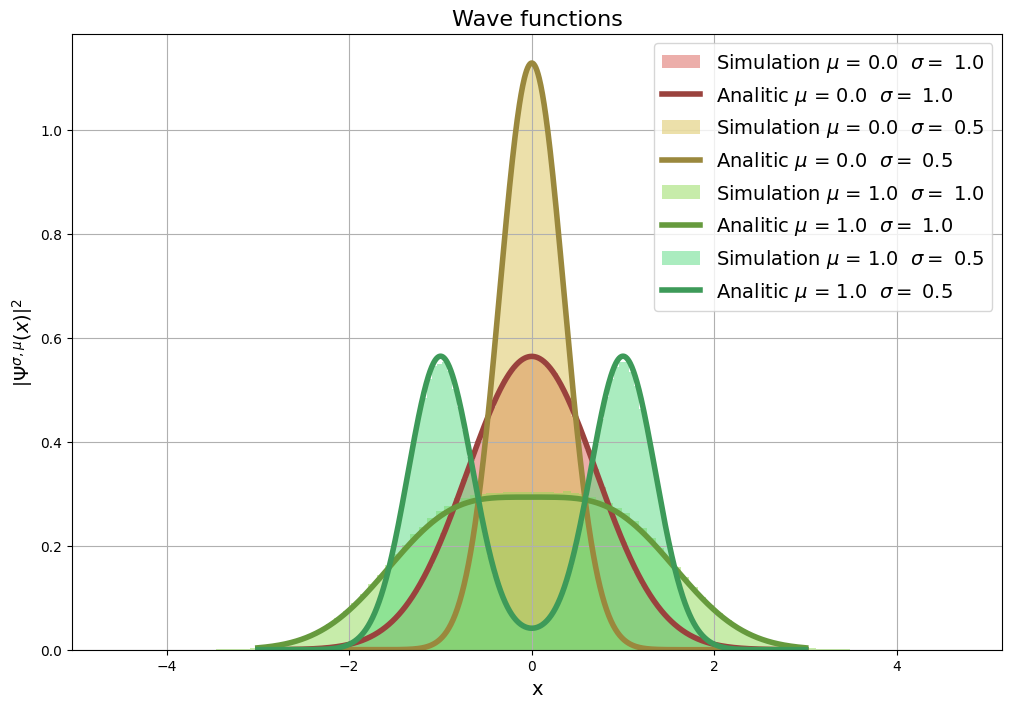

In [5]:
# Define the square modulus of the wave function
def mod_wf(x, _mu, _sigma):
    return (np.exp(-(x-_mu)**2/(2*_sigma**2))+np.exp((-(x+_mu)**2/(2*_sigma**2))))**2

file_list = glob.glob(os.path.join("../E08/e08_1/", "*_cord.dat")) # List of files

# Interval
a = 6 # x interval
N = 1000 # Number of iterations
x = np.linspace(-a/2, a/2, N)

plt.figure(figsize=(12, 8))

for k in range(len(file_list)):  # Loop over couples of parameters

    with open(file_list[k], 'r') as file:
        mu = float(file.readline().strip()) # Read first line
        sigma = float(file.readline().strip()) # Read second line

    # Data import
    df = pd.read_csv(file_list[k], skiprows=2, header=None) 

    # Plot integral sampling a uniform distribution
    plt.hist(df, bins=100, density=True, color=colors[k], alpha=0.5, label=r"Simulation $\mu$ = " + str(mu) + "  $\sigma=$ " + str(sigma))
    # Analitic function
    value, inter = np.histogram(df, bins=100)
    if (k == 0 or k == 1):
        plt.plot(x, 1. / (4 * np.sqrt(np.pi) * sigma) * mod_wf(x, mu, sigma), color=tuple(np.array(colors[k]) * 0.7), linewidth = 4, label = r"Analitic $\mu$ = " + str(mu) + "  $\sigma=$ " + str(sigma))
    if (k == 2):
        plt.plot(x, 1. / (2 * np.sqrt(2 * np.pi) * sigma) * mod_wf(x, mu, sigma), color=tuple(np.array(colors[k]) * 0.7), linewidth = 4, label = r"Analitic $\mu$ = " + str(mu) + "  $\sigma=$ " + str(sigma))
    if (k == 3):
        plt.plot(x, 1. / (2 * np.sqrt(np.pi) * sigma) * mod_wf(x, mu, sigma), color=tuple(np.array(colors[k]) * 0.7), linewidth = 4, label = r"Analitic $\mu$ = " + str(mu) + "  $\sigma=$ " + str(sigma))
    
plt.title("Wave functions", fontsize=title_size)
plt.xlabel(r'x', fontsize=axis_size)
plt.ylabel(r'$\left| \Psi^{\sigma,\mu}(x) \right|^2$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

# Show plots
plt.show()

I used the positions sampled from the square modulus wave functions to calculate $\langle {\hat H} \rangle_T$ for different pairs of parameters $\left(\mu, \sigma \right)$. Changing these parameters results in considerable changes in the energy.

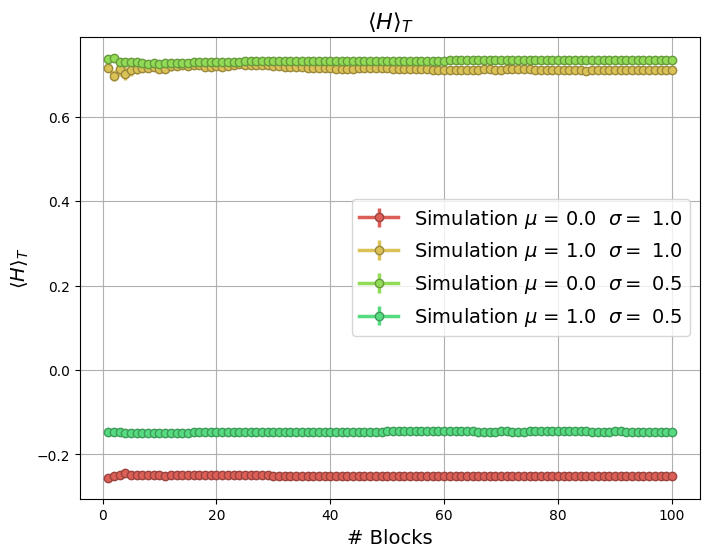

In [7]:
file_list = glob.glob(os.path.join("../E08/e08_1/", "*_mean.dat"))

plt.figure(figsize=(8, 6))

for k in range(len(file_list)):

    with open(file_list[k], 'r') as file:
        # Leggi il primo numero dalla prima riga
        mu = float(file.readline().strip())
        # Leggi il secondo numero dalla seconda riga
        sigma = float(file.readline().strip())

    # Data import
    df = pd.read_csv(file_list[k], skiprows=2, delimiter=' ') 

    # Plot integral sampling a uniform distribution
    #plt.subplot(len(file_list), 1, k + 1)
    plt.errorbar(df['#blocks'], df['mean'], yerr = df['unc'], color = colors[k], linewidth=2.5, marker='o', mec=tuple(np.array(colors[k]) * 0.7), label = r"Simulation $\mu$ = " + str(mu) + "  $\sigma=$ " + str(sigma))
    plt.title(r"$\left<H\right>_T$", fontsize=title_size)
    plt.xlabel(r'# Blocks', fontsize=axis_size)
    plt.ylabel(r'$\left<H\right>_T$', fontsize=axis_size)
    plt.legend(fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True)

# Show plots
plt.subplots_adjust(hspace=0.25)
plt.show()

## Exercise 08.2
### Assignment

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a Simulated Annealing (SA) algorithm.

Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.

- Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm.
- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps.
- show a picture of the estimation of $\langle {\hat H} \rangle_T$ and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$.
- show also a picture **of the sampled** $|\Psi_T(x)|^2$ by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

### Resolution

The Simulated Annealing (SA) algorithm allows finding the optimal parameters of the wave function $\Psi_T^{\sigma,\mu}(x)$ that minimize the energy $\langle {\hat H} \rangle_T$. At each step, new parameters are accepted with a probability that depends on the Boltzmann factor $e^{-\beta \Delta E}$, which is influenced by the temperature and the energy difference. At high temperatures, it is possible to explore the parameter space widely without getting stuck in local minima. As the temperature decreases, the system is more likely to move to states with lower energy, getting stuck in a minimum of the energy.

I computated SA starting from $T_i=2$ to $T_{end}=0.01$ updating the temperature each step decreasing by a factor 0.99 in `vector<double> simul_annealing()` function:

``` cpp
//...//
while (T > T_f)    // Loop over temperature
{
 // New parameters
 double mu = abs(wf.Get_mu() + rn.Rannyu(-1, 1) * 0.5 * T);
 double sigma = abs(wf.Get_sigma() + rn.Rannyu(-1, 1) * 0.25 * T);
 
 Wavefunction wf_new(mu, sigma); // New wave fuction
 double mean_new = 0., unc_new = 0.; // New mean and uncertainty
 metropolis_algorithm(rn, wf_new, N, block_eq, L, mean_new, unc_new); // Metropolis algorithm with new parameters
 double A = min(1., exp(- 1. / T * (mean_new - mean)));  // Transition probability with |\psi(x)|^2 

 // Accept or reject new position
 if (rn.Rannyu() < A)
 {
  // Update variables
  mean = mean_new;
  unc = unc_new;
  wf.Set_mu(wf_new.Get_mu());
  wf.Set_sigma(wf_new.Get_sigma());
 }
 // Print beta, mean, uncertainty, 
 outfile << 1. / T << " " << mean << " " << unc << " " << wf.Get_mu() << " " << wf.Get_sigma() << endl;
 T *= T_step; 	// Decrease temperature
 // Update best parameters
 if (mean < mean_best)
 {
  mean_best = mean;
  best_parameters = {wf.Get_mu(), wf.Get_sigma()};
 }
}
return best_parameters;
```

where I sampled $|\Psi_T(x)|^2$ with a Metropolis algorithm as done in the previus exercise. At the beginning, the energy varies significantly because the parameters assume very different values. As the temperature decreases the parameters change less and stabilize around the values ​​that minimize the energy, obtaining $\mu \sim 0.794$ and $\sigma \sim 0.627$.

Using these optimal parameters, I calculated $\langle {\hat H} \rangle_T$ using data blocking with $N = 100$ blocks and $L=10^5$ throws in each block, after using 40 blocks for equilibration. The energy obtained is close but not compatible with the ground state energy obtained via the matrix equation method, indicating that through SA I achieved a good approximation of the ground state but not the exact one. To improve the solution, it's possible to increase the range of temperatures by either raising the starting temperature or decreasing the ending temperature, or by changing the initial values of the parameters.

Similar to the previous exercise, I sampled the square modulus of the wave function using the optimal parameters. This wave function follows its analytic form and is very similar to the square modulus of the wave function of the ground state obtained from the matrix equation method, indicating that a state was found close to the ground state but not exactly coincident.

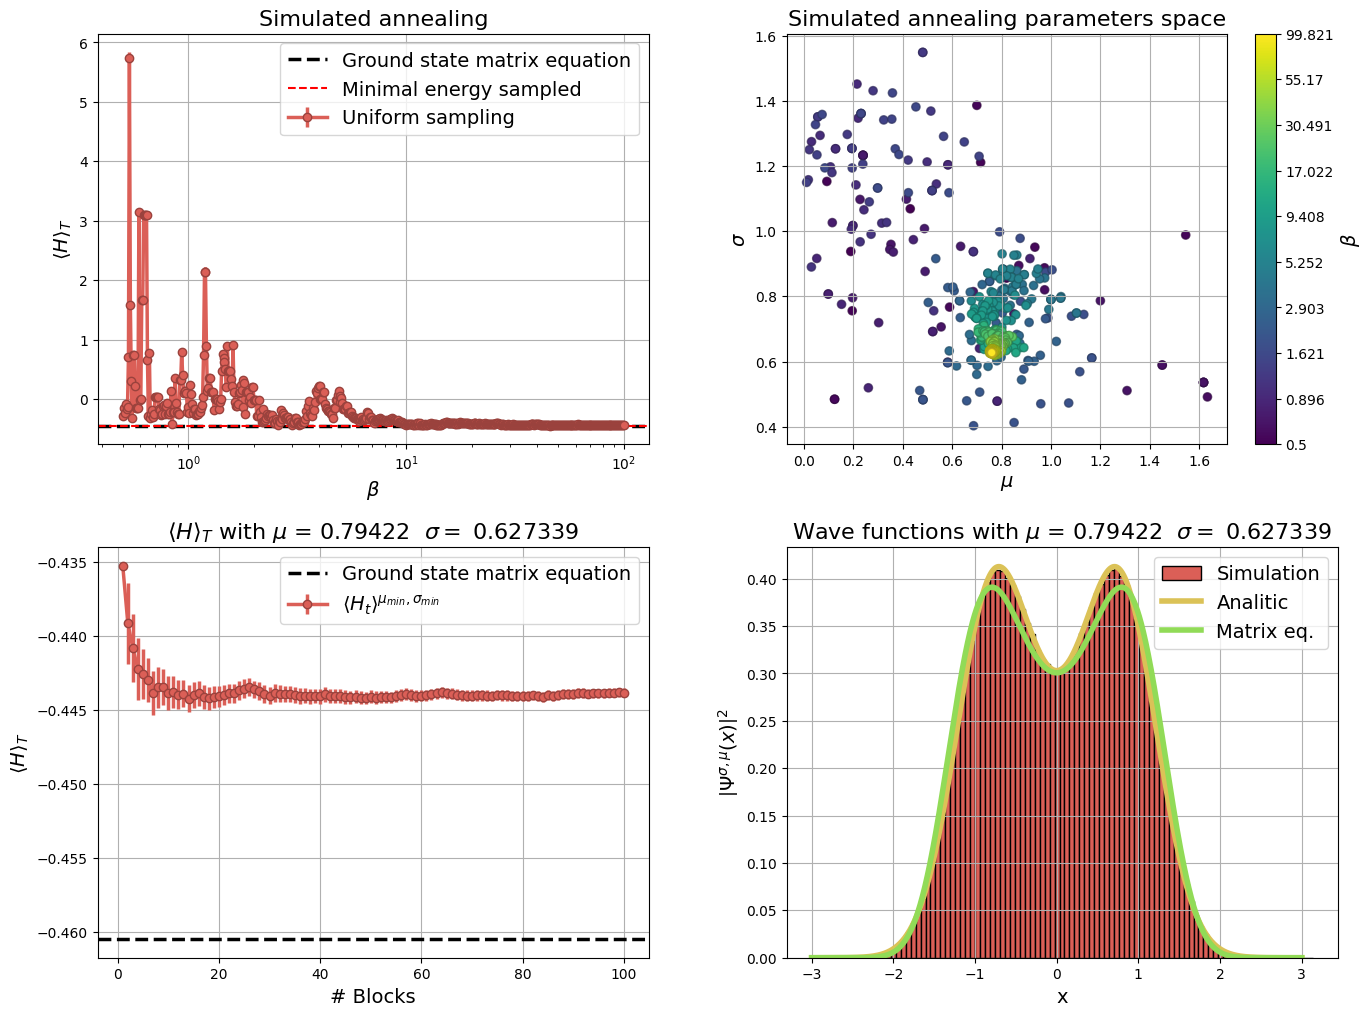

In [11]:
# Define the square modulus of the wave function
def mod_wf(x, _mu, _sigma):
    return (np.exp(-(x-_mu)**2/(2*_sigma**2))+np.exp((-(x+_mu)**2/(2*_sigma**2))))**2

# Define the potential
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

# Parameters
hbar = 1
m = 1
a = 6
N = 1000 # Number of iterations
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # Step size
V = Vpot(x) # Potential
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1) # Central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V) # Hamiltonian matrix
E, psi = np.linalg.eigh(H) # Compute eigenvectors and their eigenvalues
psi = np.transpose(psi)
psi = psi/np.sqrt(dx) # Normalize

# Data import
df = pd.read_csv('../E08/e08_2/data.dat', delimiter=' ') 
df_2 = pd.read_csv("../E08/e08_2/data_mean.dat", delimiter=' ') 
df_3 = pd.read_csv("../E08/e08_2/data_cords.dat", delimiter=' ', header = None) 

plt.figure(figsize=(16, 12))

# Plot simulated annealing
plt.subplot(2, 2, 1)
plt.errorbar(df['beta'], df['mean'], yerr = df['unc'], color = colors[0], linewidth=2.5, marker='o', mec=tuple(np.array(colors[0]) * 0.7), label = "Uniform sampling")
plt.axhline(E[0], color='black', linestyle='--', linewidth=2.5, label="Ground state matrix equation")  
plt.axhline(min(df['mean']), color='red', linestyle='--', linewidth=1.5, label="Minimal energy sampled")     # Line at ground state
plt.title("Simulated annealing", fontsize=title_size)
plt.xlabel(r'$\beta$', fontsize=axis_size)
plt.xscale('log')
plt.ylabel(r'$\left< H \right>_T$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

# Plot simulated annealing parameter space
plt.subplot(2, 2, 2)
norm = Normalize(vmin=0, vmax=len(df))
grad = cm.viridis(norm(range(len(df))))
plt.scatter(df['mu'], df['sigma'], color = grad, marker='o', edgecolors=tuple(np.array(grad) * 0.7))
plt.title("Simulated annealing parameters space", fontsize=title_size)
plt.xlabel(r'$\mu$', fontsize=axis_size)
plt.ylabel(r'$\sigma$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
cbar = plt.colorbar() # Color bar
cbar.set_label(r'$\beta$', fontsize=axis_size)
num_labels = 10 # Number of indices
indices = np.linspace(0, len(df['beta']) - 1, num_labels).astype(int) # Indices
cbar.set_ticks(np.linspace(0, 1, num_labels))
cbar.set_ticklabels(np.round(df['beta'].iloc[indices], 3))
plt.grid(True)

# Plot <H> with data blocking using optimized parameters
plt.subplot(2, 2, 3)
plt.errorbar(df_2['#blocks'], df_2['mean'], yerr = df_2['unc'], color = colors[0], linewidth=2.5, marker='o', mec=tuple(np.array(colors[0]) * 0.7), label = r"$\left<H_t\right>^{\mu_{min}, \sigma_{min}}$")
plt.axhline(E[0], color='black', linestyle='--', linewidth=2.5, label="Ground state matrix equation")      # Line at ground state
plt.title(r"$\left<H\right>_T$ with $\mu$ = " + str(df['mu'].iloc[df['mean'].idxmin()]) + "  $\sigma=$ " + str(df['sigma'].iloc[df['mean'].idxmin()]), fontsize=title_size)
plt.xlabel(r'# Blocks', fontsize=axis_size)
plt.ylabel(r'$\left<H\right>_T$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

# Plot sampled |\psi|^2 using optimized parameters 
plt.subplot(2, 2, 4)
plt.hist(df_3, bins=100, density=True, color=colors[0], edgecolor='black', label=r"Simulation")
plt.plot(x, 1. / (1.5*np.sqrt(np.pi)) * mod_wf(x, df['mu'].iloc[df['mean'].idxmin()], df['sigma'].iloc[df['mean'].idxmin()]), color=colors[1], linewidth = 4, label = r"Analitic")
plt.plot(x, (psi[0])**2,  color=colors[2], linewidth = 4, label = r"Matrix eq.")
plt.title("Wave functions with $\mu$ = " + str(df['mu'].iloc[df['mean'].idxmin()]) + "  $\sigma=$ " + str(df['sigma'].iloc[df['mean'].idxmin()]), fontsize=title_size)
plt.xlabel(r'x', fontsize=axis_size)
plt.ylabel(r'$\left| \Psi^{\sigma,\mu}(x) \right|^2$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

# Show plots
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.25)
plt.show()



### <span style="color:green">Supplementary material</span>

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.